In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

In [27]:
trump = pd.read_csv('trump_legacy/Trumps Legcy.csv')
stock = pd.read_csv('sp500_daily/sp500_stocks.csv')

In [28]:
trump['date'] = pd.to_datetime(trump['date'])
trump = trump.sort_values('date')

In [29]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

In [30]:
def is_only_link(text):
    text = text.strip()
    return text.startswith('http://') or text.startswith('https://') and ' ' not in text

# Remove rows where text is only a link
link_filtered = trump[~trump['text'].apply(is_only_link)]
link_filtered.head(10)

,id,text,device,favorites,retweets,date
13325,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00
13324,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00
13323,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00
13322,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00
13321,1773561338,"""""""My persona will never be that of a wallflow...",Twitter Web Client,1877,1321,2009-05-12 14:07:00
13320,1776419923,"""Miss USA Tara Conner will not be fired - """"I'...",Twitter Web Client,25,26,2009-05-12 19:21:00
13319,1786560616,Listen to an interview with Donald Trump discu...,Twitter Web Client,17,16,2009-05-13 17:38:00
13318,1796477499,"""""""Strive for wholeness and keep your sense of...",Twitter Web Client,26,17,2009-05-14 16:30:00
13317,1806258917,"""Enter the """"Think Like A Champion"""" signed bo...",Twitter Web Client,33,18,2009-05-15 14:13:00
13316,1820624395,"""""""When the achiever achieves, it's not a plat...",Twitter Web Client,46,19,2009-05-16 22:22:00


In [31]:
# Remove rows where text is a retweet
retweet_filtered = link_filtered[~link_filtered['text'].str.startswith('RT')]
retweet_filtered.head(10)

,id,text,device,favorites,retweets,date
13325,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00
13324,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00
13323,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00
13322,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00
13321,1773561338,"""""""My persona will never be that of a wallflow...",Twitter Web Client,1877,1321,2009-05-12 14:07:00
13320,1776419923,"""Miss USA Tara Conner will not be fired - """"I'...",Twitter Web Client,25,26,2009-05-12 19:21:00
13319,1786560616,Listen to an interview with Donald Trump discu...,Twitter Web Client,17,16,2009-05-13 17:38:00
13318,1796477499,"""""""Strive for wholeness and keep your sense of...",Twitter Web Client,26,17,2009-05-14 16:30:00
13317,1806258917,"""Enter the """"Think Like A Champion"""" signed bo...",Twitter Web Client,33,18,2009-05-15 14:13:00
13316,1820624395,"""""""When the achiever achieves, it's not a plat...",Twitter Web Client,46,19,2009-05-16 22:22:00


In [32]:
# Remove all links entirely
def remove_links(text):
    return ' '.join([word for word in text.split() if not is_only_link(word)])

retweet_filtered['text'] = retweet_filtered['text'].apply(remove_links)

C:\Users\hailea\AppData\Local\Temp\ipykernel_11560\1891951905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retweet_filtered['text'] = retweet_filtered['text'].apply(remove_links)


In [33]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

vectorized_get_polarity = np.vectorize(get_polarity)

trump['polarity'] = vectorized_get_polarity(trump['text'])

In [34]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

vectorized_get_subjectivity = np.vectorize(get_subjectivity)

trump['subjectivity'] = vectorized_get_subjectivity(trump['text'])

In [35]:
trump['polarityBinned'] = pd.cut(trump['polarity'], bins=[-1, -0.6, -0.2, 0.2, 0.6, 1], labels=['highly negative', 'negative', 'neutral', 'positive', 'highly positive'])
trump['subjectivityBinned'] = pd.cut(trump['subjectivity'], bins=[-0.25, 0, 0.25, 0.5, 0.75, 1], labels=['very objective', 'objective', 'neutral', 'subjective', 'highly subjective'])

In [36]:
polarity_mapping = {'highly negative': -1, 'negative': -0.5, 'neutral': 0, 'positive': 0.5, 'highly positive': 1}
trump['polarityNumerical'] = trump['polarityBinned'].map(polarity_mapping)
trump['polarityNumerical'] = pd.to_numeric(trump['polarityNumerical'])
trump['polarityCumulative'] = trump['polarityNumerical'].cumsum()
trump.dropna(inplace=True)

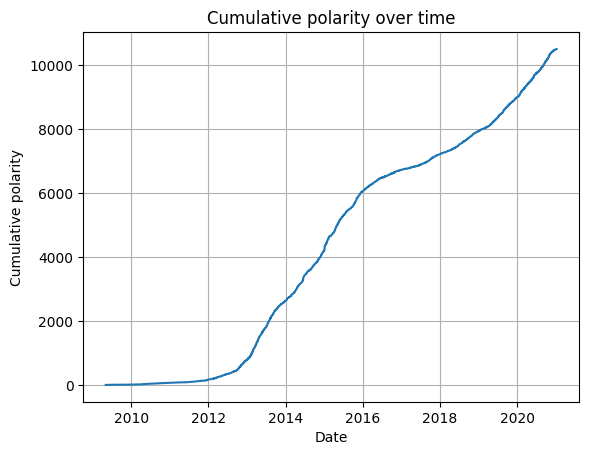

In [37]:
# Validating result is of similar trend to the EDA result
fig, ax = plt.subplots()
ax.plot(trump['date'], trump['polarityCumulative'])
ax.set(xlabel='Date', ylabel='Cumulative polarity',
       title='Cumulative polarity over time')
ax.grid()
plt.show()

In [65]:
correlations = {}
companies = stock['Symbol'].unique()

for company in companies:
    stock_min = stock[stock['Symbol'] == company]['Adj Close'].min()
    stock_max = stock[stock['Symbol'] == company]['Adj Close'].max()

    scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
    trump['polarityScaled'] = scaler.fit_transform(trump['polarityCumulative'].values.reshape(-1, 1))
    trump['polarityScaled'] = pd.to_numeric(trump['polarityScaled'])
    company_stock = stock[stock['Symbol'] == company]
    company_trump = trump[trump['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]
    adj_close = company_stock['Adj Close'].dropna()
    correlation = company_trump['polarityScaled'].corr(adj_close, method='spearman')
    correlations[company] = correlation

In [66]:
correlations = pd.Series(correlations)
correlations.dropna(inplace=True)
correlations = abs(correlations)
correlations = correlations.sort_values(ascending=False)
correlations

ADBE    0.961234
A       0.959232
ALGN    0.942025
ARE     0.917139
APD     0.886961
ACN     0.870529
AMD     0.790304
ABNB    0.541026
ABBV    0.528075
AFL     0.270258
ALB     0.225360
AOS     0.128189
ABT     0.087902
AKAM    0.059323
AES     0.056112
MMM     0.041195
dtype: float64